In [1]:
import matplotlib.pyplot as plt
import open3d as o3d
import os
import sys
import h5py
from sklearn.decomposition import PCA 
import json
from sklearn.model_selection import train_test_split
import numpy as np
sys.path.append("../..")
sys.path.append("..")   
from data.utils import distinct_colors
from models.datasets import SorghumDatasetWithNormals, TreePartNetDataset, TreePartNetOriginalDataset, SorghumDatasetTPNFormat
from models.nn_models import *
from data.load_raw_data import load_real_ply_with_labels, load_pcd_plyfile_new_approach
from data.utils import distinct_colors
from train_and_inference.test import *
from models.utils import LeafMetrics

plt.style.use('seaborn')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def load_full_size_synthetic(ind, path, is_instance = False):
    file_names = os.listdir(path)

    _, test_names = train_test_split(
        file_names,
        test_size=0.2,
        random_state=42,
    )
    
    pcd = load_pcd_plyfile_new_approach(os.path.join(path,f"{test_names[ind]}"), is_instance)
    test_data = np.expand_dims(pcd['points_full'],0)
    test_labels = np.expand_dims(pcd['labels_full'],0)
    return test_data, test_labels

In [3]:
p_metric_calc = LeafMetrics("cpu")
c_metric_calc = ClusterBasedMetrics([0.25,0.5,0.75])

In [4]:
def draw_results(plt_points, plt_labels, plt_preds):
    fig = plt.figure(figsize=(10,10))
    
    all_labels = list(set(plt_labels))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))

    gt_colors = np.zeros((plt_labels.shape[0],3))
    for i, l in enumerate(all_labels):
        gt_colors[plt_labels == l, :] = d_colors[i]

    all_labels = list(set(plt_preds))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))
        
    pred_colors = np.zeros((plt_preds.shape[0],3))
    for i, l in enumerate(list(set(plt_preds))):
        pred_colors[plt_preds == l, :] = d_colors[i]

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=gt_colors, alpha=1)
    ax1.grid(False)
    ax1.axis("off")
    ax1.set_facecolor("white")
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=pred_colors, alpha=1)
    ax2.grid(False)
    ax2.axis("off")
    ax2.set_facecolor("white")

    plt.tight_layout()
    plt.show()

def draw_and_save_pcd_plot(plt_labels, pca_raw_preds, prefix):
    if pca_raw_preds is not None:
        plt.style.use('default')

        pca_2d = PCA(n_components = 2)
        pca_2d.fit(pca_raw_preds)
        data_pca_2d = pca_2d.transform(pca_raw_preds)
        
        d_colors = distinct_colors(len(list(set(plt_labels))))
        colors = np.zeros((plt_labels.shape[0],3))
        for i, l in enumerate(list(set(plt_labels))):
            colors[plt_labels == l, :3] = d_colors[i]
            
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(1, 1, 1)
        ax1.scatter(data_pca_2d[:,0],data_pca_2d[:,1], s=5, c=colors*1.4)
        ax1.set_facecolor("white")
        ax1.spines['left'].set_color('black')
        ax1.spines['bottom'].set_color('black')
        fig.savefig(f"{prefix}_pca_plt.png")

        plt.style.use('seaborn')

def get_color_array(labels):
    all_labels = list(set(labels))
    if len(all_labels) == 3:
        d_colors = [[0.5, 0.2, 0.1], [0, 0.7, 0], [0, 0, 0.7]]
    else:
        d_colors = distinct_colors(len(all_labels))

    colors = np.zeros((labels.shape[0],3))
    for i, l in enumerate(all_labels):
        colors[labels == l, :] = d_colors[i]
    
    return colors

def draw_comparative_figures(plt_points, plt_labels, EXP1_plt_preds, EXP2_plt_preds, EXP1_pca_raw_preds, EXP2_pca_raw_preds, draw_pca = True):
    if draw_pca:
        pca_2d = PCA(n_components = 2)
        pca_2d.fit(EXP1_pca_raw_preds)
        EXP1_data_pca_2d = pca_2d.transform(EXP1_pca_raw_preds)
        pca_2d.fit(EXP2_pca_raw_preds)
        EXP2_data_pca_2d = pca_2d.transform(EXP2_pca_raw_preds)

    gt_colors = get_color_array(plt_labels)
    EXP1_colors = get_color_array(EXP1_plt_preds)
    EXP2_colors = get_color_array(EXP2_plt_preds)
    
    fig = plt.figure(figsize=(10,10))
    
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=gt_colors*1.4, alpha=1)
    ax1.grid(False)
    ax1.axis("off")
    ax1.set_facecolor("white")
    
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=EXP1_colors, alpha=1)
    ax2.grid(False)
    ax2.axis("off")
    ax2.set_facecolor("white")

    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax3.scatter(plt_points[:,0],plt_points[:,1],plt_points[:,2], s=5, c=EXP2_colors, alpha=1)
    ax3.grid(False)
    ax3.axis("off")
    ax3.set_facecolor("white")

    plt.tight_layout()
    plt.show()

    if draw_pca:
        fig = plt.figure(figsize=(10,5))
        ax4 = fig.add_subplot(1, 2, 1)
        # ax4.set_facecolor("white")
        # ax4.spines['left'].set_color('black')
        # ax4.spines['bottom'].set_color('black')
        ax4.scatter(EXP1_data_pca_2d[:,0],EXP1_data_pca_2d[:,1], s=5, c=gt_colors*1.4)
        
        ax5 = fig.add_subplot(1, 2, 2)
        ax5.scatter(EXP2_data_pca_2d[:,0],EXP2_data_pca_2d[:,1], s=5, c=gt_colors*1.4)

        plt.tight_layout()
        plt.show()

In [25]:
# Find indices of real where AP and AR are higher for Exp 03 compared to Exp 05
base_path = "/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/SorghumPartNetInstance/TPN/"
base_path_2 = "/speedy/ariyanzarei/sorghum_segmentation/results/inference_logs/TreePartNet/TPN/"

exp_03_all_res = load_json(os.path.join(base_path,"EXP_03","test_set", "full_results.json"))
exp_05_all_res = load_json(os.path.join(base_path_2,"EXP_05","test_set", "full_results.json"))

all_indices = None
for key in ['clusterbased_average_precisions','clusterbased_average_recalls']:
    metric_03 = np.array(exp_03_all_res[key])
    metric_05 = np.array(exp_05_all_res[key])
    # indices = np.argpartition(metric_03 - metric_05, -2)[-2:]
    indices = np.where(metric_03>metric_05)[0]
    if all_indices is None:
        all_indices = indices
    else:
        all_indices = np.intersect1d(all_indices, indices)
    print(key, len(indices),"/", len(metric_03), indices)
print("All Metrics", len(all_indices),"/", len(metric_03), all_indices)
ap = np.array(exp_03_all_res['clusterbased_average_precisions'])[all_indices]-np.array(exp_05_all_res['clusterbased_average_precisions'])[all_indices]
sub_indices = np.argpartition(ap, -10)[-10:]
print(all_indices[sub_indices])
print(ap[sub_indices])

clusterbased_average_precisions 440 / 440 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 

In [14]:
EXP1_model_name = "SorghumPartNetInstance"
EXP1_trained_dataset = "TPN"
EXP1_exp_no = "03"
EXP1_experiment_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/experiments/{EXP1_model_name}/{EXP1_trained_dataset}/EXP_{EXP1_exp_no}_{EXP1_model_name}_{EXP1_trained_dataset}.json"
EXP1_hyper_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/results/hparam_tuning_logs/{EXP1_model_name}/{EXP1_trained_dataset}/EXP_{EXP1_exp_no}/DBSCAN_best_param.json"

EXP1_experiment_params = load_json(EXP1_experiment_param_path)

EXP1_dataset_name = EXP1_experiment_params["dataset"]
EXP1_dataset_path = EXP1_experiment_params["test_data"]
EXP1_model_name = EXP1_experiment_params["model_name"]
EXP1_experiment_id = EXP1_experiment_params["experiment_id"]
if EXP1_dataset_name == "SPNS":
    EXP1_point_key, EXP1_label_key = "points", "labels"
elif EXP1_dataset_name == "TPN":
    EXP1_point_key, EXP1_label_key = "points", "primitive_id"
EXP1_model_path = os.path.join(
        "/speedy/ariyanzarei/sorghum_segmentation/results",
        "training_logs",
        EXP1_model_name,
        EXP1_dataset_name,
        EXP1_experiment_id,
        "checkpoints",
    )
EXP1_model = load_model(EXP1_model_name, EXP1_model_path)
# EXP1_hparams = None
EXP1_hparams = load_json(EXP1_hyper_param_path)
print(f"EXP_{EXP1_exp_no} ==> ", EXP1_hparams)

EXP_03 ==>  {'eps': 1.9972846481531603, 'minpoints': 19.0}


In [15]:
EXP2_model_name = "TreePartNet"
EXP2_trained_dataset = "TPN"
EXP2_exp_no = "05"
EXP2_experiment_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/experiments/{EXP2_model_name}/{EXP2_trained_dataset}/EXP_{EXP2_exp_no}_{EXP2_model_name}_{EXP2_trained_dataset}.json"
# EXP2_hyper_param_path = f"/speedy/ariyanzarei/sorghum_segmentation/results/hparam_tuning_logs/{EXP2_model_name}/{EXP2_trained_dataset}/EXP_{EXP2_exp_no}/DBSCAN_best_param.json"

EXP2_experiment_params = load_json(EXP2_experiment_param_path)

EXP2_dataset_name = EXP2_experiment_params["dataset"]
EXP2_dataset_path = EXP2_experiment_params["test_data"]
EXP2_model_name = EXP2_experiment_params["model_name"]
EXP2_experiment_id = EXP2_experiment_params["experiment_id"]
if EXP2_dataset_name == "SPNS":
    EXP2_point_key, EXP2_label_key = "points", "labels"
elif EXP2_dataset_name == "TPN":
    EXP2_point_key, EXP2_label_key = "points", "primitive_id"
EXP2_model_path = os.path.join(
        "/speedy/ariyanzarei/sorghum_segmentation/results",
        "training_logs",
        EXP2_model_name,
        EXP2_dataset_name,
        EXP2_experiment_id,
        "checkpoints",
    )
EXP2_model = load_model(EXP2_model_name, EXP2_model_path)
EXP2_hparams = None
# EXP2_hparams = load_json(EXP2_hyper_param_path)
# print(f"EXP_{EXP2_exp_no} ==> ", EXP2_hparams)

In [35]:
def run_inference_and_compare_synthetic(orig_ind):
    global EXP1_model, EXP2_model, EXP1_dataset_name, EXP2_dataset_name
    
    if EXP1_dataset_name == "SPNS":
        test_data, test_labels = load_full_size_synthetic(
            orig_ind,
            "/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/",
            True,
        )
    elif EXP1_dataset_name == "TPN":
        test_data, test_labels = load_data_h5(EXP1_dataset_path, "points", "primitive_id")
        test_data = test_data[orig_ind:orig_ind+1]
        test_labels = test_labels[orig_ind:orig_ind+1]
        
    ind = 0

    t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

    if EXP1_model_name == "TreePartNet":
        t_points =torch.from_numpy(test_data[ind]).type(torch.FloatTensor).to(torch.device("cuda"))
        EXP1_model = EXP1_model.to(torch.device("cuda"))
        EXP1_raw_preds = EXP1_model(t_points.unsqueeze(0))
    else:
        t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)
        EXP1_raw_preds = EXP1_model(t_points.unsqueeze(0))
    
    if EXP2_model_name == "TreePartNet":
        t_points =torch.from_numpy(test_data[ind]).type(torch.FloatTensor).to(torch.device("cuda"))
        EXP2_model = EXP2_model.to(torch.device("cuda"))
        EXP2_raw_preds = EXP2_model(t_points.unsqueeze(0))
    else:
        t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)
        EXP2_raw_preds = EXP2_model(t_points.unsqueeze(0))
    
    # ---------------------

    if EXP1_model_name == "SorghumPartNetInstance":
        EXP1_preds = get_final_clusters_SPN(
            EXP1_raw_preds, EXP1_hparams["eps"], EXP1_hparams["minpoints"]
        )
    elif EXP1_model_name == "TreePartNet":
        EXP1_preds = get_final_clusters_TPN(EXP1_raw_preds)
        EXP1_preds = EXP1_preds.numpy()

    if EXP2_model_name == "SorghumPartNetInstance":
        EXP2_preds = get_final_clusters_SPN(
                EXP2_raw_preds, EXP2_hparams["eps"], EXP2_hparams["minpoints"]
            )
    elif EXP2_model_name == "TreePartNet":
        EXP2_preds = get_final_clusters_TPN(EXP2_raw_preds)
        EXP2_preds = EXP2_preds.numpy()

    
    print(
        f"EXP_{EXP1_exp_no}",
        p_metric_calc(
            torch.from_numpy(EXP1_preds).view(1, -1, 1),
            torch.from_numpy(test_labels[ind]).view(1, -1, 1),
        ),
    )
    print(
        f"EXP_{EXP2_exp_no}",
        p_metric_calc(
            torch.from_numpy(EXP2_preds).view(1, -1, 1),
            torch.from_numpy(test_labels[ind]).view(1, -1, 1),
        ),
    )

    print(
        f"EXP_{EXP1_exp_no}",
        c_metric_calc(
            torch.from_numpy(EXP1_preds), torch.from_numpy(test_labels[ind].squeeze())
        ),
    )
    print(
        f"EXP_{EXP2_exp_no}",
        c_metric_calc(
            torch.from_numpy(EXP2_preds), torch.from_numpy(test_labels[ind].squeeze())
        ),
    )

    if EXP2_model_name == "TreePartNet":
        EXP2_raw_preds = EXP2_raw_preds[0].cpu()
        
        rotation_matrix = np.eye(4)
        rotation_matrix[1,1] = 0
        rotation_matrix[1,2] = 1
        rotation_matrix[2,1] = -1
        rotation_matrix[2,2] = 0

        test_data[ind] = np.matmul(np.hstack((test_data[ind], np.ones((test_data[ind].shape[0],1)))), rotation_matrix)[:, :3]

    draw_comparative_figures(
        test_data[ind],
        test_labels[ind].squeeze(),
        EXP1_preds,
        EXP2_preds,
        EXP1_raw_preds.squeeze().detach().numpy(),
        EXP2_raw_preds.squeeze().detach().numpy(),
        EXP2_model_name != "TreePartNet",
    )

EXP_03 (0.8490101099014282, 0.380738228559494, 0.934769332408905, 0.5410876274108887)
EXP_05 (0.8199275135993958, 0.2536649703979492, 0.4587664306163788, 0.3266924023628235)
EXP_03 {'mean_coverage': 0.5924956891607284, 'average_precision': 0.8245614035087718, 'average_recall': 0.6527777777777778}
EXP_05 {'mean_coverage': 0.13088244997653112, 'average_precision': 0.09999999999999999, 'average_recall': 0.041666666666666664}


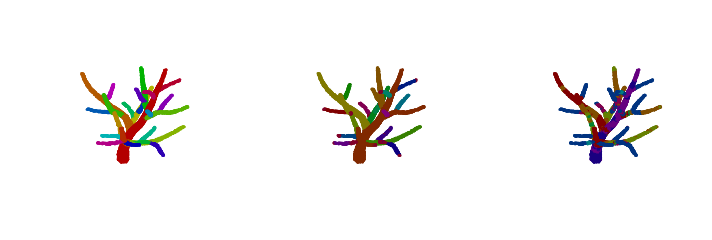

In [62]:
# [ 1006 10482  4493  8385  3974  7971  6870  7105  1782  4634]
# [12188 10139 10319  5068  7786  7926  2577  8318  6414  7712]
# [ 5044  8594 12027 11383  4841  2959   459  6852  5312  1538]
# [ 7971  8283 12164  6870  1782    699 4634  9123  7105  8122]

# [262  75 373 396 258  42 106 118 150  64]

106
118
258
396

run_inference_and_compare_synthetic(396)

(0.8199275135993958, 0.2536649703979492, 0.4587664306163788, 0.3266924023628235)
{'mean_coverage': 0.13088244997653112, 'average_precision': 0.09999999999999999, 'average_recall': 0.041666666666666664}


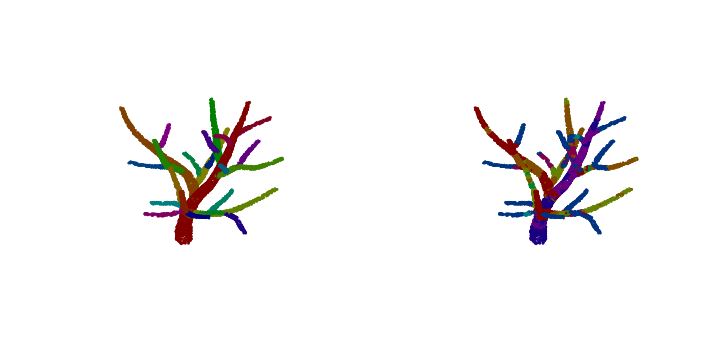

True

In [63]:
ind = 396
exp = "05"

model = EXP1_model if exp == "03" else EXP2_model
model_name = EXP1_model_name if exp == "03" else EXP2_model_name
hparams = EXP1_hparams if exp == "03" else EXP2_hparams
experiment_id = EXP1_experiment_id if exp == "03" else EXP2_experiment_id
dataset_name = EXP1_dataset_name if exp == "03" else EXP2_dataset_name
dataset_path = EXP1_dataset_path

points, label = load_data_directory("/space/ariyanzarei/sorghum_segmentation/dataset/SPNR", model_name)
if dataset_name == "SPNS":
    points, label = load_data_directory("/space/ariyanzarei/sorghum_segmentation/dataset/SPNR", model_name)
elif dataset_name == "TPN":
    points, label = load_data_h5(dataset_path, "points", "primitive_id")

if model_name == "TreePartNet":
    t_points = torch.from_numpy(points[ind]).type(torch.FloatTensor).to(torch.device("cuda"))
    model = model.to(torch.device("cuda"))
else:
    t_points = torch.from_numpy(points[ind]).type(torch.DoubleTensor)

raw_preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetSemantic":
    preds = F.softmax(raw_preds, dim=1)
    preds = preds.squeeze().cpu().detach().numpy().T
    preds = np.argmax(preds, 1)
    raw_preds = None
elif model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(raw_preds, hparams['eps'], hparams['minpoints'])
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(raw_preds, False, 0)
    preds = preds.numpy()

print(p_metric_calc(torch.from_numpy(preds).view(1,-1,1), torch.from_numpy(label[ind]).view(1,-1,1)))
print(c_metric_calc(torch.from_numpy(preds), torch.from_numpy(label[ind])))

if dataset_name == "TPN":
    rotation_matrix = np.eye(4)
    rotation_matrix[1,1] = 0
    rotation_matrix[1,2] = 1
    rotation_matrix[2,1] = -1
    rotation_matrix[2,2] = 0

    points[ind] = np.matmul(np.hstack((points[ind], np.ones((points[ind].shape[0],1)))), rotation_matrix)[:, :3]

draw_results(points[ind], label[ind], preds)
# draw_and_save_pcd_plot(label[ind].squeeze(),raw_preds.squeeze().detach().numpy(),f"{experiment_id}_real_{ind}")

gt_ply = create_ply_pcd_from_points_with_labels(points[ind],label[ind])
pred_ply = create_ply_pcd_from_points_with_labels(points[ind],preds)

R = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
gt_ply.rotate(R, center=(0, 0, 0))
pred_ply.rotate(R, center=(0, 0, 0))

o3d.io.write_point_cloud(f"{experiment_id}_real_{ind}_gt.ply", gt_ply)
o3d.io.write_point_cloud(f"{experiment_id}_real_{ind}_pred.ply", pred_ply)

(0.7616302967071533, 0.19849826395511627, 0.403854638338089, 0.26617103815078735)
{'mean_coverage': 0.22267927246246186, 'average_precision': 0.08333333333333333, 'average_recall': 0.1111111111111111}


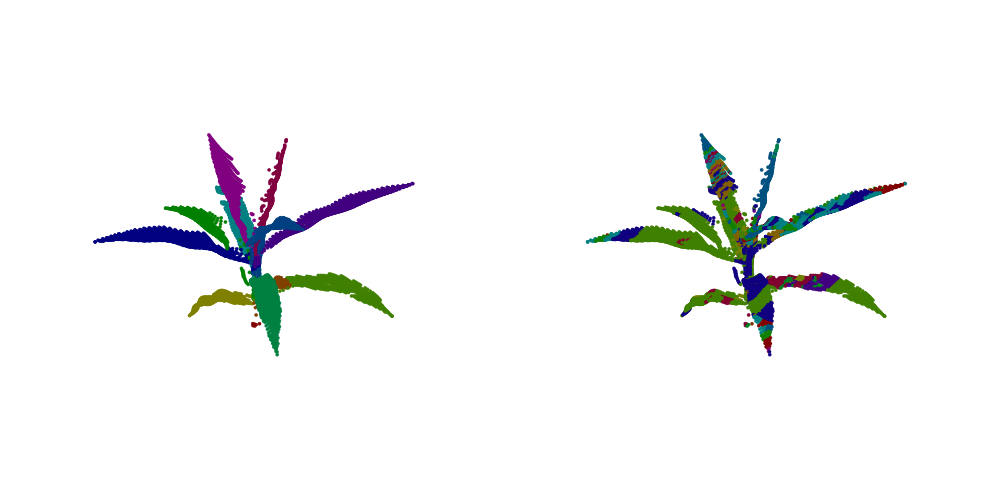

True

In [57]:
# hparams = {"eps": 1, "minpoints": 15}

orig_ind = 1
exp = "04"

model = EXP1_model if exp == "08" else EXP2_model
model_name = EXP1_model_name if exp == "08" else EXP2_model_name
hparams = EXP1_hparams if exp == "08" else EXP2_hparams
experiment_id = EXP1_experiment_id if exp == "08" else EXP2_experiment_id

test_data, test_labels = load_full_size_synthetic(orig_ind,"/space/ariyanzarei/sorghum_segmentation/dataset/archive/synthetic/2022-12-26/PointCloud/", True)
ind = 0

t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

if model_name == "TreePartNet":
    t_points = torch.from_numpy(test_data[ind]).type(torch.FloatTensor).to(torch.device("cuda"))
    model = model.to(torch.device("cuda"))
else:
    t_points = torch.from_numpy(test_data[ind]).type(torch.DoubleTensor)

raw_preds = model(t_points.unsqueeze(0))

if model_name == "SorghumPartNetInstance":
    preds = get_final_clusters_SPN(raw_preds, hparams['eps'], hparams['minpoints'])
elif model_name == "TreePartNet":
    preds = get_final_clusters_TPN(raw_preds, False, 0)
    preds = preds.numpy()

print(p_metric_calc(torch.from_numpy(preds).view(1,-1,1), torch.from_numpy(test_labels[ind]).view(1,-1,1)))
print(c_metric_calc(torch.from_numpy(preds), torch.from_numpy(test_labels[ind].squeeze())))

draw_results(test_data[ind], test_labels[ind].squeeze(), preds)
# draw_and_save_pcd_plot(test_labels[ind].squeeze(),raw_preds.squeeze().detach().numpy(),f"{experiment_id}_syn_{orig_ind}")

save_points = (test_data[ind] - np.min(test_data[ind], 0))
gt_ply = create_ply_pcd_from_points_with_labels(save_points,test_labels[ind].squeeze())
pred_ply = create_ply_pcd_from_points_with_labels(save_points,preds)

R = o3d.geometry.get_rotation_matrix_from_xyz((-np.pi/2, 0, 0))
gt_ply.rotate(R, center=(0, 0, 0))
pred_ply.rotate(R, center=(0, 0, 0))

o3d.io.write_point_cloud(f"{experiment_id}_syn_{orig_ind}_gt.ply", gt_ply)
o3d.io.write_point_cloud(f"{experiment_id}_syn_{orig_ind}_pred.ply", pred_ply)